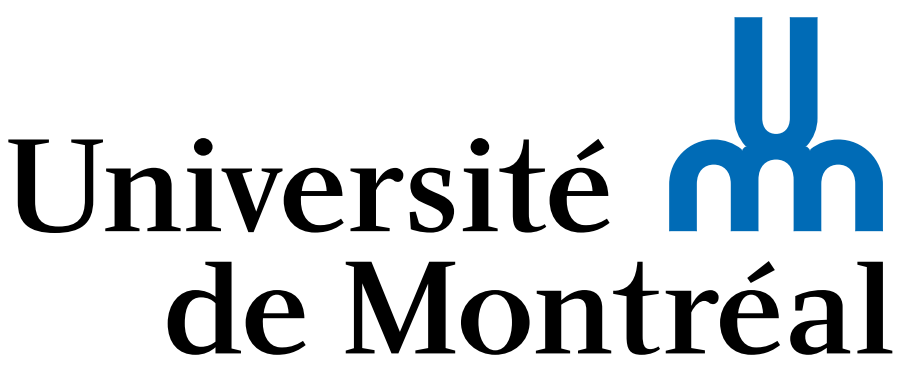

# IFT6285 (TALN) 

## Devoir 2: Modèles n-grammes avec kenlm

Réalisé par:

Mouna Dhaouadi 

Kacem Khaled

Soumis à:

Prof. Philippe Langlais

Frédéric Piedboeuf


**Automne 2021**

In [69]:
pip install https://github.com/kpu/kenlm/archive/master.zip

  Using cached https://github.com/kpu/kenlm/archive/master.zip
  Created wheel for kenlm: filename=kenlm-0.0.0-cp38-cp38-linux_x86_64.whl size=2972490 sha256=7f6a07842e227a813e0e7faa0a33bd607ab0f1d5bb280fb3b8ddfe880f3ef65d
  Stored in directory: /tmp/pip-ephem-wheel-cache-01qdq0ys/wheels/ff/08/4e/a3ddc0e786e0f3c1fcd2e7a82c4324c02fc3ae2638471406d2
Successfully built kenlm
Note: you may need to restart the kernel to use updated packages.


In [66]:
import kenlm

model = kenlm.Model(kenlm_dir+'lm/test.arpa')
print(model.score('this is a sentence .', bos = True, eos = True))


-49.579345703125


In [16]:
import kenlm
import time
from tqdm import tqdm
import os
from os import listdir
import subprocess
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
folder = 'training-monolingual.tokenized.shuffled/'
folder_short = '1bshort/'
folder_test = 'heldout-monolingual.tokenized.shuffled/'
kenlm_dir = '/home/kacem/kenlm/' 

In [8]:
a  = subprocess.run('ls',  capture_output=True,text=True)


In [9]:
print(a.stdout)

1bshort
TP2.ipynb
bigram0.arpa
bigram1.arpa
bigram2.arpa
bigram3.arpa
bigram4.arpa
bigram5.arpa
bigram6.arpa
bigram7.arpa
bigram8.arpa
bigram9.arpa
heldout-monolingual.tokenized.shuffled
models
text.txt
training-monolingual.tokenized.shuffled



In [10]:
def train(folder):
    files = listdir(folder)
    times = []
    sizes = []
    start_time = time.time()
    fns = ""
    filenames = ['file1.txt', 'file2.txt', ...]
    
    for i,fn in enumerate(files):
        fns += folder+fn+' '
        training_sample = "models/text.txt"
        os.system("cat "+fns+ " > "+ training_sample)
        print(fns)
        cmd = kenlm_dir+'/build/bin/lmplz -o 2 -S 80% -T /tmp < '+training_sample+' > models/bigram'+str(i+1)+'.arpa'
        print(cmd)
        os.system(cmd)
        times.append(time.time() - start_time)
        size = os.path.getsize('models/bigram'+str(i+1)+'.arpa') 
        sizes.append(size)
    return times,sizes

In [11]:
times,sizes = train(folder_short)

1bshort/news.en-00001-of-00100 
/home/kacem/kenlm//build/bin/lmplz -o 2 -S 80% -T /tmp < text.txt > models/bigram1.arpa
1bshort/news.en-00001-of-00100 1bshort/news.en-00002-of-00100 
/home/kacem/kenlm//build/bin/lmplz -o 2 -S 80% -T /tmp < text.txt > models/bigram2.arpa
1bshort/news.en-00001-of-00100 1bshort/news.en-00002-of-00100 1bshort/news.en-00003-of-00100 
/home/kacem/kenlm//build/bin/lmplz -o 2 -S 80% -T /tmp < text.txt > models/bigram3.arpa
1bshort/news.en-00001-of-00100 1bshort/news.en-00002-of-00100 1bshort/news.en-00003-of-00100 1bshort/news.en-00004-of-00100 
/home/kacem/kenlm//build/bin/lmplz -o 2 -S 80% -T /tmp < text.txt > models/bigram4.arpa
1bshort/news.en-00001-of-00100 1bshort/news.en-00002-of-00100 1bshort/news.en-00003-of-00100 1bshort/news.en-00004-of-00100 1bshort/news.en-00005-of-00100 
/home/kacem/kenlm//build/bin/lmplz -o 2 -S 80% -T /tmp < text.txt > models/bigram5.arpa
1bshort/news.en-00001-of-00100 1bshort/news.en-00002-of-00100 1bshort/news.en-00003-of-001

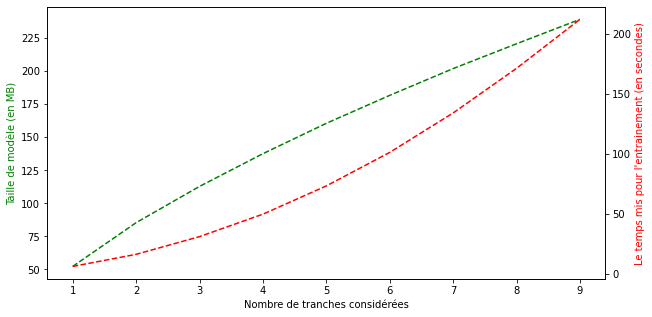

In [20]:
tranches = list(range(1,10))
fig, ax = plt.subplots(figsize=(10, 5))
sizes_mb = [s/(1024*1024) for s in sizes]
ax.plot(tranches, sizes_mb  , 'g--') # convert to MB
ax.set_xlabel("Nombre de tranches considérées")
ax.set_ylabel("Taille de modèle (en MB)", color = 'g')

ax2=ax.twinx()

ax2.plot(tranches, times,'r--')
ax2.set_xlabel("Nombre de tranches considérées)")
ax2.set_ylabel("Le temps mis pour l'entrainement (en secondes)", color = 'r')

plt.show()

In [70]:
d = {'Tranches': tranches, 'Tailles des modèles (MB)': sizes_mb, 'Temps d\'entrainement (s)': times }
df_results = pd.DataFrame(data=d, index = list(range(1,10)))
df_results.style.format(formatter={('Tranches'): "{:d}",
                           ( 'Tailles des modèles (MB)'):"{:.2f}" ,
                           ( 'Temps d\'entrainement (s)'):"{:.2f}" 
                          })

,Tranches,Tailles des modèles (MB),Temps d'entrainement (s)
1,1,52.29,6.11
2,2,85.39,16.20
3,3,112.84,30.96
4,4,137.61,49.68
5,5,160.58,73.23
6,6,181.73,101.16
7,7,201.99,134.06
8,8,220.77,171.27
9,9,239.24,212.08


In [73]:
df_results.T

,1,2,3,4,5,6,7,8,9
Tranches,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000
Tailles des modèles (MB),52.287684,85.385287,112.839401,137.606860,160.577271,181.731882,201.988606,220.768402,239.237977
Temps d'entrainement (s),6.108294,16.198564,30.959870,49.676706,73.229051,101.163268,134.057457,171.271166,212.077601


In [13]:
files = listdir(folder_short)
model = kenlm.Model('models/bigram9.arpa')
test_file = listdir(folder_test)

def test(folder_test):
    perplex = []
    with open(folder_test+test_file[0], 'r',encoding="utf8") as f:
        lines = f.readlines(1000)
        for line in lines:
            perplex.append(model.perplexity(line))
    f.close()
    return perplex


In [14]:
perplexities = test(folder_test)

In [15]:
from statistics import mean
print(f"Mean:\t{mean(perplexities)}\nMax:\t{max(perplexities)}\nMin:\t{min(perplexities)}")


Mean:	433.1266004940858
Max:	1594.5263921569774
Min:	65.1040745110339
